
# 项目：TMDb电影分析报告

## 目录
<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda1">探索：问题1</a></li>
<li><a href="#ques1">结论：问题1</a></li>
<li><a href="#eda2">探索：问题2</a></li>
<li><a href="#ques2">结论：问题2</a></li>
<li><a href="#result">总结论</a></li>
</ul>

<a id='intro'></a>
## 简介

> **提示**：本分析报告基于TMDb电影数据库，包含自1960年以来的电影数据。

> 问题1：各类电影的数量分布情况是怎样的？每年最受欢迎的电影类别是哪些？

> 问题2：什么样的电影最可能获得高票房？

In [44]:
# 导入语句。
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline


<a id='wrangling'></a>
## 数据整理

> **提示**：在报告的这一部分中载入数据，检查简洁度，然后整理和清理数据集，以便进行分析。请务必将步骤仔细归档，并确定清理决策是否正确。

### 常规属性

In [45]:
# 加载数据并打印几行。进行这几项操作，来检查数据
# 类型，以及是否有缺失数据或错误数据的情况。
t_movies = pd.read_csv('tmdb-movies.csv')
t_movies.head(2)
#t_movies.info()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08


### 开始清理

In [46]:
# 清理其中缺失值过多同时与本次分析无关的列
t_movies.drop(['homepage', 'tagline', 'keywords', 'production_companies'], axis=1, inplace=True)

In [47]:
# 清理包含空值的行
t_movies.dropna(inplace=True);
#t_movies.info()

In [48]:
# 经检验，预算与票房的零值太多，因此不作填充，直接删除相应行。
zerobud_index = t_movies.query('budget==0').index
t_movies.drop(zerobud_index, axis=0, inplace=True)
zerorev_index = t_movies.query('revenue==0').index
t_movies.drop(zerorev_index, axis=0, inplace=True)

In [49]:
# 删除重复行
t_movies.duplicated().sum()
t_movies.drop_duplicates(inplace=True)
t_movies.duplicated().sum()

0

In [50]:
# 转换时间类型
t_movies.release_date = pd.to_datetime(t_movies.release_date)
t_movies.release_year = pd.to_datetime(t_movies.release_year, format='%Y')


### 清理结束

In [51]:
#查看整理结果
t_movies.info()
#t_movies.describe()
#t_movies.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3849 entries, 0 to 10848
Data columns (total 17 columns):
id                3849 non-null int64
imdb_id           3849 non-null object
popularity        3849 non-null float64
budget            3849 non-null int64
revenue           3849 non-null int64
original_title    3849 non-null object
cast              3849 non-null object
director          3849 non-null object
overview          3849 non-null object
runtime           3849 non-null int64
genres            3849 non-null object
release_date      3849 non-null datetime64[ns]
vote_count        3849 non-null int64
vote_average      3849 non-null float64
release_year      3849 non-null datetime64[ns]
budget_adj        3849 non-null float64
revenue_adj       3849 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(5), object(6)
memory usage: 541.3+ KB


<a id='eda1'></a>
## 探索：问题1
### 每年最受欢迎的电影类别是那些

In [52]:
# 将电影类型分割为细类,形成新的数据集(stack()：分行堆叠)
genres = t_movies['genres'].str.split('|', expand=True)
# 分行堆叠
genres = genres.stack()

# 重设索引
genres = genres.reset_index(level=0).set_index('level_0').rename(columns={0:'genres'})

#合并数据
df_genres = genres.join(t_movies.drop('genres', axis=1))
#df_genres.head()

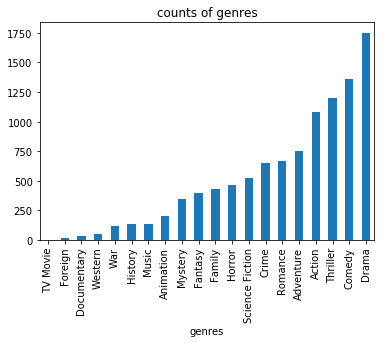

In [53]:
# 统计出各类电影的数量分布情况
genres_count = df_genres.groupby('genres').id.count().sort_values()
genres_count.plot(y='counts', title='counts of genres', kind='bar')

In [54]:
# 获得每年最受欢迎的影片类型(unstack()：取消堆叠)
genres_pop = df_genres.groupby(['release_year', 'genres'])['popularity'].mean()
genres_pop.unstack().idxmax(axis=1)

release_year
1960-01-01             Horror
1961-01-01          Animation
1962-01-01           Thriller
1963-01-01          Adventure
1964-01-01             Action
1965-01-01           Thriller
1966-01-01              Drama
1967-01-01          Animation
1968-01-01            Mystery
1969-01-01             Action
1970-01-01          Animation
1971-01-01             Family
1972-01-01              Drama
1973-01-01          Animation
1974-01-01              Crime
1975-01-01          Adventure
1976-01-01              Crime
1977-01-01             Action
1978-01-01              Music
1979-01-01             Horror
1980-01-01          Adventure
1981-01-01          Adventure
1982-01-01    Science Fiction
1983-01-01          Adventure
1984-01-01             Family
1985-01-01             Family
1986-01-01          Animation
1987-01-01                War
1988-01-01          Animation
1989-01-01          Animation
1990-01-01            Western
1991-01-01          Animation
1992-01-01          Animati

<a id='ques1'></a>
### 结论--问题1：
上图清晰展现了各类别的电影的数量分布情况。

同时以上列表也列出了1960年至2015年期间，每年最受欢迎的电影类别。

<a id='eda2'></a>
## 探索：问题2
### 那些电影最可能获得高票房

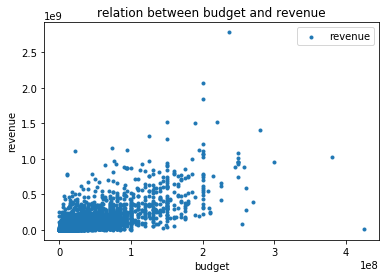

In [55]:
# 研究票房与投资预算的关系
plt.scatter(t_movies.budget,t_movies.revenue,marker='.')
plt.title('relation between budget and revenue')
plt.xlabel('budget');
plt.ylabel('revenue');
plt.legend()


如上图所示，投资与票房具有一定的正相关性

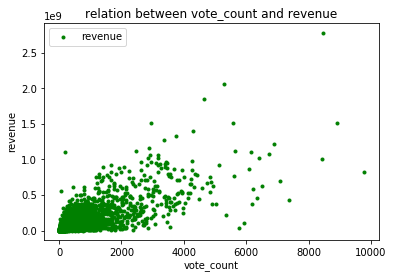

In [56]:
# 研究票房与投票数的关系
plt.scatter(t_movies.vote_count,t_movies.revenue,marker='.', color='green')
plt.title('relation between vote_count and revenue')
plt.xlabel('vote_count');
plt.ylabel('revenue');
plt.legend()

如上图所示，投票数与票房具有一定的正相关性

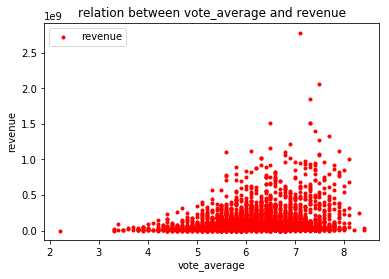

In [57]:
# 研究票房与评分的关系
plt.scatter(t_movies.vote_average,t_movies.revenue,marker='.', color='red')
plt.title('relation between vote_average and revenue')
plt.xlabel('vote_average');
plt.ylabel('revenue');
plt.legend()

如上图所示，电影评分与票房具有一定的正相关性

<a id='ques2'></a>
### 结论--问题2：由以上分析可知，高投资、高关注、高评分的电影，更可能获得高票房。

<a id='result'></a>
## 总结论
    数据样本中存在过多无效值，类似空值以及投资、票房中的零值，由于数量较大，填充并无太大意义，因此直接删除。而清理完毕后的数据只剩下不到四成，代表性明显不足，因而在统计各年度最受欢迎的电影时，结果可能失真，但通过这些清理后的数据仍可看出那些因素最可能跟票房相关。